<a href="https://colab.research.google.com/github/ashwinamrutphale/aml-homeworks/blob/master/homework_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

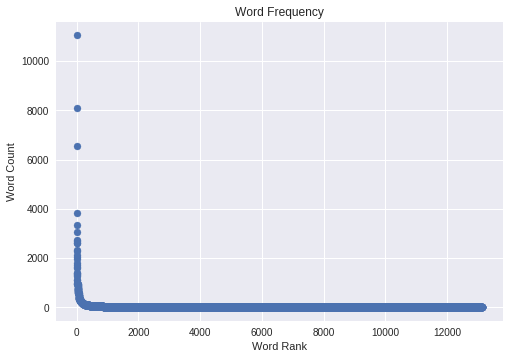

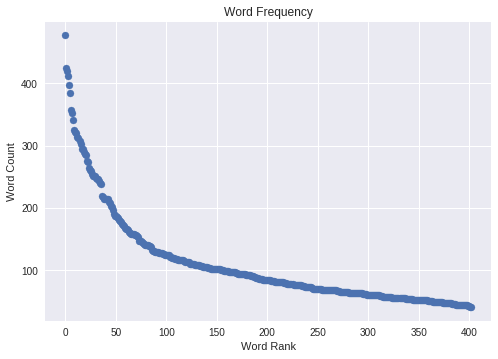

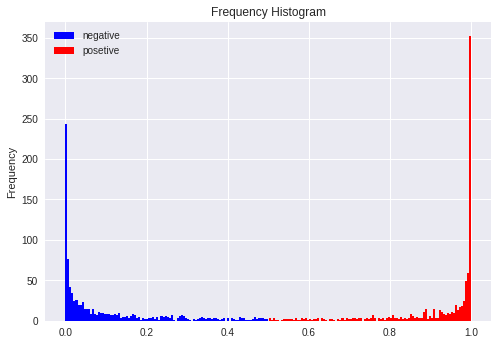

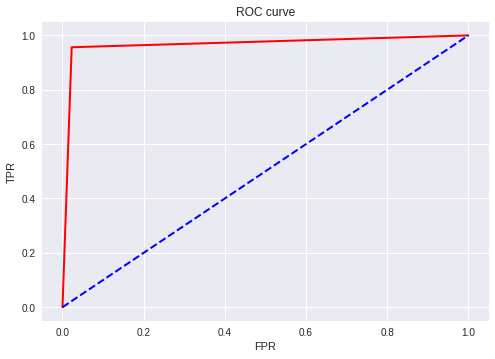

                      0
accuracy       0.966667
recall         0.977728
precision      0.956427
roc_auc_score  0.966691
                      0
accuracy       0.880000
recall         0.862745
precision      0.897959
roc_auc_score  0.880352
                      0
accuracy       0.935000
recall         1.000000
precision      0.884729
roc_auc_score  0.935144
                      0
accuracy       0.875000
recall         0.960784
precision      0.823529
roc_auc_score  0.873249
                      0
accuracy       0.933889
recall         0.869710
precision      0.997446
roc_auc_score  0.933747
                      0
accuracy       0.860000
recall         0.784314
precision      0.930233
roc_auc_score  0.861545


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import nltk
from sklearn.feature_extraction import stop_words
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score, recall_score, precision_score
from google.colab import files

def plot(bag_of_words):
  sum_words = bag_of_words.sum(axis=0) 
  f = np.sort(sum_words)
  y = np.squeeze(np.asarray(f[0:1,::-1]))
  x_coordinate = [i for i in range(len(y))]
  plt.scatter(x_coordinate, y)
  plt.gca().set(title='Word Frequency', ylabel='Word Count',xlabel='Word Rank')
  plt.show()

def get_stop_words_plot(data):
  vectorizer =CountVectorizer()
  bag_of_words = vectorizer.fit_transform(data)
  stop_word = []
  plot(bag_of_words)
  for word in stop_words.ENGLISH_STOP_WORDS:
    if word in vectorizer.vocabulary_:
      stop_word.append(word)
  return stop_word
    
class Vector:
  def __init__(self,vector,bag_of_words):
    self.vector = vector
    self.bag_of_words = bag_of_words
    
def get_final_bfw(data,stop_words,min_df,max_df):
  vectorizer = CountVectorizer(stop_words=stop_words,max_df=max_df, min_df=min_df)
  bag_of_words = vectorizer.fit_transform(data)
  plot(bag_of_words)
  return Vector(vectorizer,bag_of_words)

def get_nearest_neighbors(data,vector,point,n):
  neigh = NearestNeighbors(n_neighbors=n)
  neigh.fit(vector.bag_of_words)
  x = v.vector.transform(point)
  r = neigh.kneighbors(x, return_distance=True) 
  return data.iloc[r[1][0]],r[0]

def predict_with_threshold(clf,input_df,labels,threshold):
  preds = np.where(clf.predict_proba(input_df)[:,1] > threshold, 1, 0)
  return pd.DataFrame(data=[accuracy_score(labels, preds), recall_score(labels, preds),
                   precision_score(labels, preds), roc_auc_score(labels, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

binary = lambda x: 1 if x == 5 else 0

input_df = pd.read_csv('http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/yelp_2k.csv')

words = get_stop_words_plot(input_df["text"])
v = get_final_bfw(input_df["text"],words,40,400)
x = v.vector.transform(["Horrible customer service"])
d = get_nearest_neighbors(input_df,v,["Horrible customer service"],100)
df_features = pd.DataFrame(v.bag_of_words.toarray())
feature = df_features.join(input_df["stars"])

train_df,test_df = train_test_split(feature, test_size=0.10, random_state=42)
train_labels = train_df["stars"].map(binary).values.flatten()
test_labels = test_df["stars"].map(binary).values.flatten()
clf = LogisticRegression(random_state=0, solver='liblinear').fit(train_df.values[:,:-1],train_labels) 

predict_with_threshold(clf,train_df.values[:,:-1],train_labels,0.5)
predict_with_threshold(clf,test_df.values[:,:-1],test_labels,0.5)

clf.score(train_df.values[:,:-1],train_labels)
clf.score(test_df.values[:,:-1],test_labels)

prob = pd.DataFrame(clf.predict_proba(train_df.values[:,:-1]))
pred = pd.DataFrame(clf.predict(train_df.values[:,:-1]))
prob.rename(columns={0:'pos'}, inplace=True)
pred.rename(columns={0:'res'}, inplace=True)

r = prob.join(pred)
x1 = r.loc[r.res==1,'pos']
x2 = r.loc[r.res==0,'pos']
plt.hist(x1, 100, color='b', label='negative')
plt.hist(x2, 100, color='r', label='posetive')
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')
plt.legend();

fpr, tpr,_=roc_curve(clf.predict(train_df.values[:,:-1]),train_labels,drop_intermediate=False)

plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

print(predict_with_threshold(clf,train_df.values[:,:-1],train_labels,0.50))
print(predict_with_threshold(clf,test_df.values[:,:-1],test_labels,0.50))
print(predict_with_threshold(clf,train_df.values[:,:-1],train_labels,0.25))
print(predict_with_threshold(clf,test_df.values[:,:-1],test_labels,0.25))
print(predict_with_threshold(clf,train_df.values[:,:-1],train_labels,0.75))
print(predict_with_threshold(clf,test_df.values[:,:-1],test_labels,0.75))
  

